# FDTD

### Libraries

In [83]:
import numpy as np
import math
from matplotlib import pyplot as plt 
import pandas as pd
from scipy.fft import fft, fftfreq

### Variables and constants

In [84]:
lambda_min = 600e-9  #minimum lambda in the wavelength regime.
lambda_max = 1000e-9  #maximum lambda in wavelength regime.
min_lam_sf = 10     #safety factor for the min labmda.
min_dim = 1.6779*10**-2       #minimum dimension
res_sf = 10          #resolution safety factor
c0 = 299792458  #speed of light.
critic_dim = 1.6779*10**-2 #a critical dimension that needs to be represented well
layer1_dim = critic_dim
layer2_dim = 0.3048
layer3_dim = critic_dim
eps_layer1 = 3.46
n_layer1 = np.sqrt(eps_layer1)
eps_layer2 = 12
n_layer2 = np.sqrt(eps_layer2)
eps_layer3 = 3.46
n_layer3 = np.sqrt(eps_layer3)
n_bc = 1  #refractive index of boundaries
n_max = max(n_layer1, n_layer2, n_layer3)

In [145]:
layers_thickness = {} #dictionary
layers_start = {} #dictionary
layers_end = {} #dictionary
spacer = 800e-9 #arbitrary, change it
# Dictionary of layer thicknesses.
for t in range(0, 30):
    if t%2 == 0: # if even
        layers_thickness["layer_%s"% str(t)] = 122e-9
    else:
        layers_thickness["layer_%s"% str(t)] = 163e-9
def past_layers_thick(n_layers):
    past_layers_thickness = 0
    for i in range(0, n_layers):
        past_layers_thickness+= layers_thickness["layer_%s"% str(i)] 
    return past_layers_thickness

layers_start["layer_0"] = spacer       
for x in range(1, 30):
    #start=spacer+earlier layerS thicknesses
    layers_start["layer_%s"% str(x)] = spacer + past_layers_thick(x) 

for p in range(0, 30):
    layers_end["layer_%s"% str(p)] = layers_start["layer_%s"% str(p)]\
    + layers_thickness["layer_%s"% str(p)]

### Grid Resolution

delta_z is the pixel length. 
delta_z_init is the minimum of two options:
a- lambda_min/safety factor
b- minimum dimension/safety factor
we initialize it and then snap the grid to the critical dimension

In [85]:
delta_z_init = min(lambda_min / min_lam_sf, min_dim / res_sf)
print(delta_z_init)
N = math.ceil(critic_dim/ delta_z_init)
print(N)
dz = critic_dim / N
print(dz)

N_layer1 = layer1_dim/dz
N_layer2 = layer2_dim/dz
N_layer3 = layer3_dim/dz

N_device = N_layer1+N_layer2+N_layer3

print(N_device)
N = N_device + (2*lambda_max) #spacer regions for visualising and/or for BC in 2D.
print(N)
N= math.ceil(N)
print(N)

0.0016779
10
0.0016779
201.65564097979617
226.65564097979617
227


### Building device

In [86]:
# build a device
ER_yy = np.ones(N) # air
UR_xx = np.ones(N) # air and ALMOST all other materials.

def build_layer_middle(N):  
    device_start_pos = int(N/2) - round(N_device/2)
    device_end_post = int(N/2) + math.ceil(N_device/2)
    ER_yy[device_start_pos : device_end_post] = n_device**2
    return ER_yy

lay1_start = int(lambda_max)
lay1_end = int(lay1_start + N_layer1)

lay2_start = lay1_end
lay2_end = int(lay2_start + N_layer2)

lay3_start = lay2_end
lay3_end = int(lay3_start + N_layer3)

ER_yy[lay1_start : lay1_end] = eps_layer1
ER_yy[lay2_start : lay2_end] = eps_layer2
ER_yy[lay3_start : lay3_end] = eps_layer3



### Visualising device

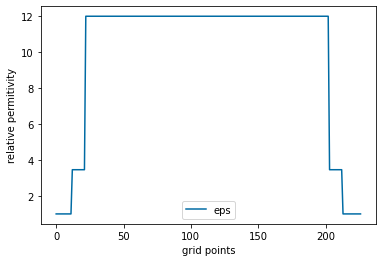

In [87]:
plt.style.use('tableau-colorblind10')
plt.plot(ER_yy, label = 'eps')
plt.xlabel("grid points")
plt.ylabel("relative permitivity")
plt.legend()
plt.show()

In [88]:
# plt.plot(ER_yy, color = 'green', label = 'device')
# plt.hlines(1, 0, device_start_pos, colors='blue', linestyles='solid', linewidth = 4, label='air')
# plt.hlines(1, device_end_post, N, colors='blue', linestyles='solid', linewidth = 4)
# plt.xlabel("grid points")
# plt.ylabel("relative permitivity")
# plt.legend()

### Time step

  time step, physical wave would not propagate further than a single unit cell in one time step.

In [89]:
dt= n_bc * dz / (2 * c0)  # Courant condition.

### Source

Since fmax = 1/pi.taw --> taw =~ 0.5/fmax.
The pulse source must start at zero and gradually increase. NO STEP FUNCTIONS

In [90]:
f_max = c0 / lambda_min

taw = 0.5 / f_max

t0 = 6 * taw
def g(t):
    """
    g(t): Gaussian source function
    """
    return   np.exp(-((t -  t0) / taw)**2)   
f_max * 10**-12

0.004996540966666667

### TFSF

TFSF separates the total field and the scattered field into two separate regions. This is particularly useful for creating a one-way source, and for calculating the transmission and reflection spectra. 

In the separation, the equations should be adjusted because of the finite differencing, we have some points at the total field that take the field value of the scattered field and vice versa. 

In [91]:
f_max = c0 / lambda_min
taw = 0.5 / f_max
t0 = 6 * taw
def Ey_src(t):
    """
    g(t): Gaussian source function
    """
    return   np.exp(-((t -  t0)/taw)**2)   



A = -1
dt_src = (dt/2) + dz/(2*c0)
def Hx_src(t):
    """
    g(t): Gaussian source function
    """
    
    return   A*np.exp(-((t-t0+dt_src) / taw)**2)   
    

# Ey_src = np.vectorize(Ey_src)
# Hx_src = np.vectorize(Hx_src) 

### Computations

Update coefficients are constants that will be used in the code below continiously, to save computation time, we calculate them once.

In [92]:
# Update coefficients
mEy = c0 * dt / ER_yy
mHx = c0 * dt / UR_xx
# initialize fields
Ey = np.zeros(N)
Hx = np.zeros(N)

### Magnetic Field Normalization

The divergence equations were satisfied by adopting the Yee grid scheme. Now, only the the
curl equations have to be dealt with.
The 𝐸 and 𝐻 fields are related through the impedance of the material they are in, so they are
roughly three orders of magnitude different.

This may cause rounding errors in simulation and it is always good practice to normalize
parameters so they are all the same order of magnitude. Here, the magnetic field is
normalized

Normalization: H_tilde = eta_0 * H, eta_0 = 300

### Calculating number of time steps

How long does it take a wave to propagate across the grid (worst case)?

Simulation time T must include the entire pulse of duration.
Simulation time should allow for 5 bounces.

A rule-of-thumb for total simulation time is then 5 t_prop + 12 * taw.

In [93]:
t_prop = n_max * N * dz / c0
T = 12*taw + 5* t_prop
STEPS = math.ceil(T/dt)
STEPS

8293

In [94]:
Ey_t = np.zeros([STEPS, N]) #time evolution of the fields

In [95]:
# # MAIN FDTD LOOP with perfect boundary conditions
# H1 = 0
# H2 = 0
# E1 = 0
# E2 = 0
# nzsrc = 10
    
# Ey_t = np.zeros([STEPS, N]) #time evolution of the field for all points.
# Hx_t = np.zeros([STEPS, N]) #time evolution of the field for all points.
# for T in range(STEPS):        
#     #Update H from E
#     #modificaion
#     H2=H1
#     H1=Hx[0]
#     for nz in range(N-1):
#         Hx[nz] = Hx[nz] + mHx[nz]*(Ey[nz+1] - Ey[nz])/dz
#         Hx_t[T][nz] = Hx[nz] #recording field as a matrix
#     Hx[N-1] = Hx[N-1] + mHx[N-1]*(E2 - Ey[N-1])/dz #1D PML
#     # E2 = the field at the second last point of the grid two time steps earlier.
#     Hx[nzsrc] = Hx[nzsrc] + mHx[nzsrc]*(Ey[nzsrc+1] - Ey[nzsrc])/dz\
#     -(Ey_src(T*dt) * mHx[nzsrc]/dz) #update equation with correction term of the TF/SF
# #     Hx[nzsrc-1] = Hx[nzsrc-1] + mHx[nzsrc-1]*\
# #     (Ey[nzsrc] - Ey[nzsrc-1])/dz-(Ey_src(T*dt) * mHx[nzsrc-1]/dz) #update equation with 
# #     # correction term of the TF/SF
    
    
            
#     Hx_t[T][N-1] = Hx[N-1] #recording field as a matrix
           
#     #Update E from H
#     #modification
#     E2=E1
#     E1=Ey[N-1]
#     Ey[0] = Ey[0] + mEy[0] * (Hx[0] - H2) / dz #1D PML.

#     Ey_t[T][0] = Ey[0]
    
#     for nz in range(1, N):
#         Ey[nz] = Ey[nz] + mEy[nz]*(Hx[nz] - Hx[nz-1])/dz
                    
#         Ey_t[T][nz] = Ey[nz] #recording field as a matrix
        
#     Ey[nzsrc] = Ey[nzsrc] + mEy[nzsrc]*(Hx[nzsrc] - Hx[nzsrc-1])/dz\
#     - Hx_src(T*dt) * mEy[nzsrc-1]/dz   


In [96]:
# Working code wo FT.
# # MAIN FDTD LOOP with perfect boundary conditions
# H1 = 0
# H2 = 0
# E1 = 0
# E2 = 0
# nzsrc = 2
    
# Ey_t = np.zeros([STEPS, N]) #time evolution of the field for all points.
# Hx_t = np.zeros([STEPS, N]) #time evolution of the field for all points.
# for T in range(STEPS):        
#     #Update H from E
#     #modificaion
#     H2=H1
#     H1=Hx[0]
#     for nz in range(N-1):
#         Hx[nz] = Hx[nz] + mHx[nz]*(Ey[nz+1] - Ey[nz])/dz
#         Hx_t[T][nz] = Hx[nz] #recording field as a matrix
#     Hx[N-1] = Hx[N-1] + mHx[N-1]*(E2 - Ey[N-1])/dz #1D PML
#     # E2 = the field at the second last point of the grid two time steps earlier.
#     Hx[nzsrc-1] = Hx[nzsrc-1]\
#     -(Ey_src(T*dt) * mHx[nzsrc]/dz) #update equation with correction term of the TF/SF
# #     Hx[nzsrc-1] = Hx[nzsrc-1] + mHx[nzsrc-1]*\
# #     (Ey[nzsrc] - Ey[nzsrc-1])/dz-(Ey_src(T*dt) * mHx[nzsrc-1]/dz) #update equation with 
# #     # correction term of the TF/SF
    
    
            
#     Hx_t[T][N-1] = Hx[N-1] #recording field as a matrix
           
#     #Update E from H
#     #modification
#     E2=E1
#     E1=Ey[N-1]
#     Ey[0] = Ey[0] + mEy[0] * (Hx[0] - H2) / dz #1D PML.

#     Ey_t[T][0] = Ey[0]
    
#     for nz in range(1, N):
#         Ey[nz] = Ey[nz] + mEy[nz]*(Hx[nz] - Hx[nz-1])/dz
                    
#         Ey_t[T][nz] = Ey[nz] #recording field as a matrix
        
#     Ey[nzsrc] = Ey[nzsrc]\
#     - Hx_src(T*dt) * mEy[nzsrc-1]/dz   


In [ ]:
# # MAIN FDTD LOOP with perfect boundary conditions and FT.
# for T in range(STEPS):        
#     #Update H from E:
#     for nz in range(N-1):
#         Hx[nz] = Hx[nz] + mHx[nz]*(Ey[nz+1] - Ey[nz])/dz
                       
#     #Update E from H
#     for nz in range(1, N):
#         Ey[nz] = Ey[nz] + mEy[nz]*(Hx[nz] - Hx[nz-1])/dz

In [97]:
# MAIN FDTD LOOP with perfect boundary conditions and FT.
H1 = 0
H2 = 0
E1 = 0
E2 = 0
nzsrc = 4
NFREQ = 1000
FREQ = np.linspace(0, f_max, NFREQ)
#Fourier Transforms:
K = np.exp(-1j*2*np.pi*dt*FREQ).astype(complex)
EyR = np.zeros(NFREQ).astype(complex)
EyT = np.zeros(NFREQ).astype(complex)
SRC = np.zeros(NFREQ).astype(complex)


    
Ey_t = np.zeros([STEPS, N]) #time evolution of the field for all points.
Hx_t = np.zeros([STEPS, N]) #time evolution of the field for all points.
for T in range(STEPS):        
    #Update H from E
    #modificaion
    H2=H1
    H1=Hx[0]
    for nz in range(N-1):
        Hx[nz] = Hx[nz] + mHx[nz]*(Ey[nz+1] - Ey[nz])/dz
        Hx_t[T][nz] = Hx[nz] #recording field as a matrix
    Hx[N-1] = Hx[N-1] + mHx[N-1]*(E2 - Ey[N-1])/dz #1D PML
    # E2 = the field at the second last point of the grid two time steps earlier.
    Hx[nzsrc-1] = Hx[nzsrc-1]\
    -(Ey_src(T*dt) * mHx[nzsrc]/dz) #update equation with correction term of the TF/SF
#     Hx[nzsrc-1] = Hx[nzsrc-1] + mHx[nzsrc-1]*\
#     (Ey[nzsrc] - Ey[nzsrc-1])/dz-(Ey_src(T*dt) * mHx[nzsrc-1]/dz) #update equation with 
#     # correction term of the TF/SF
   
    
            
    Hx_t[T][N-1] = Hx[N-1] #recording field as a matrix
           
    #Update E from H
    #modification
    E2=E1
    E1=Ey[N-1]
    Ey[0] = Ey[0] + mEy[0] * (Hx[0] - H2) / dz #1D PML.

    Ey_t[T][0] = Ey[0]
    
    for nz in range(1, N):
        Ey[nz] = Ey[nz] + mEy[nz]*(Hx[nz] - Hx[nz-1])/dz
                    
        Ey_t[T][nz] = Ey[nz] #recording field as a matrix
        
    Ey[nzsrc] = Ey[nzsrc]\
    - Hx_src(T*dt) * mEy[nzsrc-1]/dz 
#Update Fourier Transforms
    for nf in range(0, NFREQ):
            EyR[nf] = EyR[nf] + (K[nf]**(T+1))*Ey[1]
            EyT[nf] = EyT[nf] + (K[nf]**(T+1))*Ey[N-1]
            SRC[nf] = SRC[nf] + (K[nf]**(T+1))*Ey_src((T+1)*dt)


In [98]:
EyR_ = EyR*dt
EyT_ = EyT*dt
SRC_ = SRC*dt




EyR_abs = np.abs(EyR_)
EyT_abs = np.abs(EyT_)
SRC_abs = np.abs(SRC_)

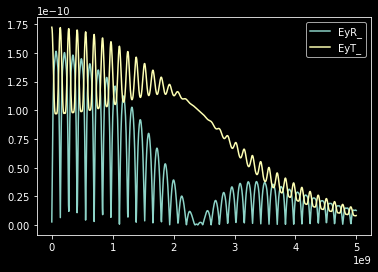

In [99]:
plt.style.use('dark_background')

plt.plot(FREQ, EyR_abs, label = 'EyR_')
plt.plot(FREQ, EyT_abs, label = 'EyT_')

plt.legend()
plt.show()

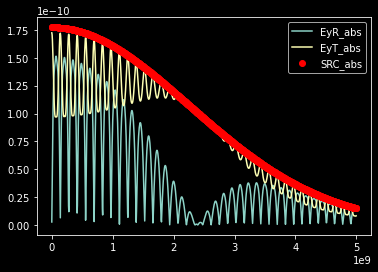

In [100]:
plt.style.use('dark_background')

plt.plot(FREQ, EyR_abs, label = 'EyR_abs')
plt.plot(FREQ, EyT_abs, label = 'EyT_abs')
plt.plot(FREQ, SRC_abs, 'or', label = 'SRC_abs', linewidth = 0.2)


plt.legend()
plt.show()

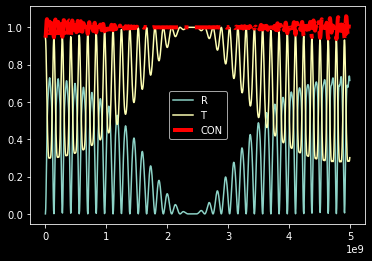

In [101]:
plt.style.use('dark_background')


T = (EyT_abs/SRC_abs)**2
R = (EyR_abs/SRC_abs)**2
CON= T + R 


plt.plot(FREQ, R, label = 'R')
plt.plot(FREQ, T, label = 'T')
plt.plot(FREQ, CON, '-.r', label = 'CON', linewidth = 4)


plt.legend()
plt.show()

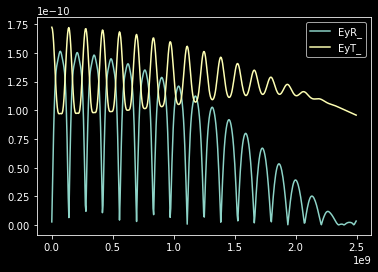

In [102]:
plt.style.use('dark_background')

plt.plot(FREQ[0:500], EyR_abs[0:500], label = 'EyR_')
plt.plot(FREQ[0:500], EyT_abs[0:500], label = 'EyT_')

plt.legend()
plt.show()

In [103]:
g_vector = np.vectorize(g)
source_t = g_vector(time_axis)
source_f = np.abs(fft(source_t))
plt.plot(time_axis, source_t, label = 'time')

plt.legend()
plt.show()

NameError: name 'time_axis' is not defined

In [ ]:
# plt.plot(FREQ, source_f, label = 'frequency')
# plt.show()
NFREQ = STEPS
FREQ = np.linspace(0, f_max, NFREQ)

In [ ]:
plt.style.use('dark_background')
plt.plot(FREQ, EyR_abs, label = 'EyR_')
plt.plot(FREQ, EyT_abs, label = 'EyT_')
plt.plot(FREQ, source_f*10**-16, label = 'source')

plt.legend()
plt.show()


In [ ]:
EyR_abs[0:978].shape

In [ ]:
R = EyR_abs[0:978]/source_pos
T = EyT_abs[0:978]/source_pos



In [ ]:
# freqs = FREQ[0:978]
# plt.plot(freqs, R, label = 'R')
# plt.plot(freqs, T, label = 'T')
# plt.legend()
# plt.show()

In [ ]:
x = np.array([1,2,3]).astype(complex)
x[:2] = np.array([1+2j, 1-2j])
x

Below is a simple source.

In [ ]:
# # MAIN FDTD LOOP with perfect boundary conditions
# H1 = 0
# H2 = 0
# E1 = 0
# E2 = 0


# Ey_t = np.zeros([STEPS, N]) #time evolution of the field for all points.
# Hx_t = np.zeros([STEPS, N]) #time evolution of the field for all points.

# for T in range(STEPS):        
#     #Update H from E
#     #modificaion
#     H2=H1
#     H1=Hx[0]
#     for nz in range(N-1):
#             Hx[nz] = Hx[nz] + mHx[nz]*(Ey[nz+1] - Ey[nz])/dz
#             Hx_t[T][nz] = Hx[nz] #recording field as a matrix
#     Hx[N-1] = Hx[N-1] + mHx[N-1]*(E2 - Ey[N-1])/dz #1D PML
#     # E2 = the field at the second last point of the grid two time steps earlier.

#     Hx_t[T][N-1] = Hx[N-1] #recording field as a matrix
           
#     #Update E from H
#     #modification
#     E2=E1
#     E1=Ey[N-1]
#     Ey[0] = Ey[0] + mEy[0] * (Hx[0] - H2) / dz #1D PML.

#     Ey_t[T][0] = Ey[0]
    
#     for nz in range(1, N):
#             Ey[nz] = Ey[nz] + mEy[nz]*(Hx[nz] - Hx[nz-1])/dz 
            
#             Ey_t[T][nz] = Ey[nz] #recording field as a matrix
            
#     Ey[2] = Ey[2] +g(T*dt)  # Simple source, gE is stored in an array of length STEPS    
#     #Ey[10] = g(T*dt)

In [ ]:
#Denormalization of H field: would be hard to visualize.
# eta_0 = 300
# Hx_t =  Hx_t/eta_0
    

In [ ]:
#Source, and fourier transforming:

time_stamps = np.linspace(0, STEPS*dt, STEPS)
N_time_stamps = time_stamps.shape[0]
time_spacing= dt
freqs = fftfreq(N_time_stamps, time_spacing)

Ey_src_vectorized = np.vectorize(Ey_src)
Source_T = []
for T in range(STEPS):
    Source_T.append(Ey_src_vectorized(T*dt))
Source_F = fft(Source_T)
plt.figure(figsize=(13,7))
plt.plot(time_stamps, Source_T)
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
source_pos = np.abs(Source_F)[0:int(freqs.shape[0]/2)].reshape(-1,1)
plt.plot(freqs[0:int(freqs.shape[0]/2)],source_pos )
plt.xlabel("frequencies", fontsize = 20)
plt.ylabel("Spectrum", fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

In [ ]:
last_field = Ey_t[:, cell_number].reshape(-1,1)
first_field = Ey_t[:, 0].reshape(-1,1)

plt.figure(figsize=(20,10))
T = fft(last_field)
R= fft(first_field)

In [ ]:
time_axis = np.linspace(0, dt*STEPS, STEPS)
cell_number = N-1
plt.figure(figsize=(17,15))
plt.subplot(221)
plt.plot(time_axis, Ey_t[:, cell_number]) #field at 
plt.title("field at cell number " +str(cell_number), fontsize = 18)


plt.xlabel("time", fontsize = 20)
plt.ylabel("E field Transmission", fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)


cell_number = 0
plt.subplot(222)
plt.plot(time_axis, Ey_t[:, cell_number]) #field at 
plt.title("field at cell number " +str(cell_number), fontsize = 18)

plt.xlabel("time", fontsize = 18)
plt.ylabel("E field Reflection", fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)


plt.show()

In [ ]:
# freqs1 = np.linspace(0, f_max, STEPS)
# freqs = fftfreq(N_time_stamps, time_spacing)
# print(freqs)
# print(freqs1)


In [ ]:
# #FFT of the last cell --> Transmission
# from scipy.fft import fft, fftfreq
# from sklearn import preprocessing

# #last_field_normalized = preprocessing.normalize(Ey_t[:, cell_number].reshape(-1,1))
# #first_field_normalized = preprocessing.normalize(Ey_t[:, 0].reshape(-1,1))
# last_field = Ey_t[:, cell_number].reshape(-1,1)
# first_field = Ey_t[:, 0].reshape(-1,1)
# time_stamps = np.linspace(0, STEPS*dt, STEPS)
# N_time_stamps = time_stamps.shape[0]
# time_spacing= dt
# freqs = fftfreq(N_time_stamps, time_spacing)
# #freqs = np.linspace(0, f_max, STEPS)
# plt.figure(figsize=(20,10))
# T = fft(last_field)
# R= fft(first_field)
# freq_pos = freqs[0:int(freqs.shape[0]/2)]
# T_pos = np.abs(T)[0:int(freqs.shape[0]/2)]
# R_pos = np.abs(R)[0:int(freqs.shape[0]/2)]
# CON_pos = T_pos + R_pos
# plt.plot(freq_pos, T_pos, label = "T", linewidth = 5)
# plt.plot(freq_pos,R_pos , label = "R", linewidth = 5)
# plt.plot(freq_pos, source_pos/max(source_pos), label = "source",  linewidth = 5)

# #plt.plot(freq_pos, CON, 'ro', label = "CON")
# #plt.plot(freqs, np.abs(T), label = "T")
# #plt.plot(freqs, np.abs(R), label = "R")
# #plt.scatter(freqs, np.abs(T)  + abs(R), label = "CON")
# plt.legend(fontsize = 25, loc='best')
# plt.xlabel("frequencies", fontsize = 25)
# plt.ylabel("Spectrum", fontsize = 25)
# plt.xticks(fontsize = 25)
# plt.yticks(fontsize = 25)
# plt.show()


In [ ]:
#plots normalized:


# plt.plot(freq_pos, T_pos/(source_pos), label = "T")
# plt.plot(freq_pos,R_pos/(source_pos) , label = "R")
# plt.plot(freq_pos, CON/(source_pos), 'ro', label = "CON")
# plt.legend()

In [ ]:
time_step = 0
%matplotlib inline
plt.plot(Ey_t[time_step, :]) 
plt.title("field at time step " +str(time_step))

# this is our frame Ey_t[time_step, :]


In [ ]:
Ey_t

In [ ]:
time_step = 40
%matplotlib inline
plt.plot(Ey_t[time_step, :]) 
plt.title("field at time step " +str(time_step))

# this is our frame Ey_t[time_step, :]


In [ ]:
plt.plot(Hx_t[:, 1])

### Creating animation for the fields evolutions

In [104]:
%matplotlib nbagg

In [105]:
%matplotlib inline

In [106]:
# save numpy array as csv file
from numpy import asarray
from numpy import savetxt
# define data
Edata = Ey_t
Hdata = Hx_t
# save to csv file
savetxt('Edata.csv', Edata, delimiter=',')
savetxt('Hdata.csv', Hdata, delimiter=',')

In [107]:
Efield = pd.read_csv('Edata.csv')
Hfield = pd.read_csv('Hdata.csv')


In [108]:
# for i in Efield.shape[0]:
#     if 

In [109]:
Efield

,0.000000000000000000e+00,0.000000000000000000e+00.1,0.000000000000000000e+00.2,-5.798807075608924085e-17,5.798807075608924085e-17,0.000000000000000000e+00.3,0.000000000000000000e+00.4,0.000000000000000000e+00.5,0.000000000000000000e+00.6,0.000000000000000000e+00.7,...,0.000000000000000000e+00.215,0.000000000000000000e+00.216,0.000000000000000000e+00.217,0.000000000000000000e+00.218,0.000000000000000000e+00.219,0.000000000000000000e+00.220,0.000000000000000000e+00.221,0.000000000000000000e+00.222,0.000000000000000000e+00.223,0.000000000000000000e+00.224
0,0.000000e+00,0.000000e+00,-1.449702e-17,-1.056525e-16,2.492928e-16,6.237714e-17,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
1,0.000000e+00,-3.624254e-18,-4.815864e-17,-8.812806e-17,3.602379e-16,2.226521e-16,1.559429e-17,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
2,-9.060636e-19,-1.747604e-17,-8.067902e-17,-1.315272e-17,4.011191e-16,4.585071e-16,7.905447e-17,3.898572e-18,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
3,-5.954622e-18,-4.298608e-17,-8.051708e-17,5.849610e-17,4.586010e-16,7.143522e-16,2.185888e-16,2.561147e-17,9.746429e-19,0.000000e+00,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
4,-1.935498e-17,-6.862100e-17,-3.621910e-17,7.025498e-17,6.262902e-16,9.616299e-16,4.338197e-16,8.940951e-17,7.864833e-18,2.436607e-19,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8287,-2.002887e-03,-2.291646e-03,-2.530375e-03,-2.712755e-03,-2.833844e-03,-2.890216e-03,-2.880058e-03,-2.803231e-03,-2.661285e-03,-2.457425e-03,...,-0.000001,-0.000001,-8.062466e-07,-4.070302e-07,5.138801e-08,5.133387e-07,9.216070e-07,1.224491e-06,1.382307e-06,0.000001
8288,-2.152832e-03,-2.417450e-03,-2.628723e-03,-2.781001e-03,-2.870083e-03,-2.893341e-03,-2.849792e-03,-2.740142e-03,-2.566775e-03,-2.333699e-03,...,-0.000001,-0.000001,-9.676216e-07,-6.159736e-07,-1.801724e-07,2.874192e-07,7.294535e-07,1.090610e-06,1.324484e-06,0.000001
8289,-2.291176e-03,-2.529917e-03,-2.712322e-03,-2.833448e-03,-2.889866e-03,-2.879764e-03,-2.803001e-03,-2.661124e-03,-2.457337e-03,-2.196430e-03,...,-0.000001,-0.000001,-1.097684e-06,-8.038787e-07,-4.037853e-07,5.511033e-08,5.170805e-07,9.249085e-07,1.226947e-06,0.000001
8290,-2.417016e-03,-2.628301e-03,-2.780601e-03,-2.869718e-03,-2.893019e-03,-2.849522e-03,-2.739931e-03,-2.566628e-03,-2.333620e-03,-2.046444e-03,...,-0.000001,-0.000001,-1.192770e-06,-9.652118e-07,-6.126976e-07,-1.764299e-07,2.911720e-07,7.327594e-07,1.093066e-06,0.000001


In [110]:
STEPS

8293

In [111]:
!cd

C:\Users\Ahmed
